## 0. Configurations

In [1]:
# ====================================================================
# STEP 0: Import Libraries
# ====================================================================
# 과제에 사용할 library들을 import

# 시스템 및 입출력 관련
import os  # 디렉토리, 파일 경로 조작 등
from PIL import Image  # 이미지 열기 및 처리 (Pillow)
from tqdm import tqdm  # 반복문의 진행 상태 시각화
from pathlib import Path  # payhon path
import shutil # 파일 복사/이동

# 시각화 도구
import matplotlib.pyplot as plt  # 기본 시각화
import matplotlib
# 한글 폰트 설정 (Windows의 기본 한글 폰트)
matplotlib.rc('font', family='Malgun Gothic')
# 마이너스 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False
import matplotlib.patches as patches

# 주피터 노트북에서 이미지 인라인 표시를 위한 매직 명령어 추가 (여기 추가)
%matplotlib inline

# 이미지 처리
import cv2  # OpenCV - 고급 이미지/비디오 처리

# 수치 연산
import numpy as np  # 배열, 벡터 계산 등

# 통계 tool
import pandas as pd
from collections import defaultdict, Counter

# 싸이킷런 데이터 나누기
from sklearn.model_selection import train_test_split

# JSON
import json

# YOLOv8 라이브러리
from ultralytics import YOLO


In [2]:
# 디바이스 설정
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [3]:
# ====================================================================
# STEP 1: Define Paths
# ====================================================================
PROJECT_ROOT = Path("/Users/user/myproject/AI03-Project-1")
DATA_ROOT = Path("/Users/user/myproject/AI03-Project-1/data/raw") # 실제 데이터 경로로 변경 필요
train_image_dir = DATA_ROOT / "train_images"
train_ann_path = DATA_ROOT / "train_annotations"
test_image_dir = DATA_ROOT / "test_images"


In [4]:
# YOLOv8 데이터를 저장할 새 디렉토리
YOLO_DATA_ROOT = Path("/Users/user/myproject/AI03-Project-1/data") / "processed" / "yolov8_dataset"
YOLO_IMAGES_TRAIN = YOLO_DATA_ROOT / "images" / "train"
YOLO_LABELS_TRAIN = YOLO_DATA_ROOT / "labels" / "train"
YOLO_IMAGES_VAL = YOLO_DATA_ROOT / "images" / "val"
YOLO_LABELS_VAL = YOLO_DATA_ROOT / "labels" / "val"
YOLO_LABELS_TEMP = Path("/Users/user/myproject/AI03-Project-1/data") / "processed" / "yolo_labels_temp" # 변환된 .txt 파일을 임시로 저장할 곳


In [5]:
# 디렉토리 생성
os.makedirs(YOLO_IMAGES_TRAIN, exist_ok=True)
os.makedirs(YOLO_LABELS_TRAIN, exist_ok=True)
os.makedirs(YOLO_IMAGES_VAL, exist_ok=True)
os.makedirs(YOLO_LABELS_VAL, exist_ok=True)
os.makedirs(YOLO_LABELS_TEMP, exist_ok=True)



## 1. Data-preprocessing

In [6]:
# ====================================================================
# STEP 2: Parse Annotations and Convert to YOLO Format
# ====================================================================

def create_yolo_annotations_and_map_final(annotation_root: Path, train_image_dir: Path, yolo_labels_output_dir: Path):
    """
    제공된 복잡한 JSON 어노테이션 폴더 구조를 파싱하고 YOLO 형식(.txt)으로 변환하여 저장합니다.
    - train_images: 이미지 파일들 (예: K-XXXXX_Y_Z.png)
    - train_annotations:
        - K-XXXXX_Y_Z_json/ (이미지 그룹 폴더)
            - K-AAAAA/ (개별 약제 ID 폴더)
                - K-XXXXX_Y_Z.json (해당 이미지 내 K-AAAAA 약제의 어노테이션)

    각 이미지에 대한 어노테이션이 여러 JSON 파일(각 알약별)에 분산되어 있으므로
    JSON 파일명이 원본 이미지 파일명과 동일한 형태를 처리합니다.
    """
    
    category_id_to_name = {}
    
    # 1. 모든 JSON 파일을 스캔하여 category_id_to_name 맵 수집
    # 모든 JSON 파일에서 클래스 정보를 한 번에 수집합니다.
    all_json_paths_for_categories_scan = []
    for dirpath, _, filenames in os.walk(annotation_root):
        for fname in filenames:
            if fname.endswith('.json'):
                all_json_paths_for_categories_scan.append(os.path.join(dirpath, fname))

    print(f"Scanning {len(all_json_paths_for_categories_scan)} JSON files to collect categories...")
    
    for json_path in tqdm(all_json_paths_for_categories_scan, desc="Collecting categories"):
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                if 'categories' in data:
                    for cat in data['categories']:
                        category_id_to_name[cat['id']] = cat['name']
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Warning: Could not parse categories from {json_path} due to {e}. Skipping.")
            continue

    sorted_category_ids = sorted(list(category_id_to_name.keys()))
    yolo_class_id_map = {cat_id: idx for idx, cat_id in enumerate(sorted_category_ids)}
    yolo_idx_to_name_map = {idx: category_id_to_name[cat_id] for cat_id, idx in yolo_class_id_map.items()}

    print(f"\nDetected {len(sorted_category_ids)} unique categories.")
    
    for cat_id in sorted_category_ids:
        print(f"  Original ID: {cat_id}, YOLO ID: {yolo_class_id_map[cat_id]}, Name: {category_id_to_name[cat_id]}")

    # 2. train_images 폴더의 모든 이미지 파일 목록을 확보
    all_image_files_in_dir = []
    # 이미지 확장자들을 유연하게 처리
    for ext in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG']: 
        all_image_files_in_dir.extend(list(train_image_dir.glob(f"*{ext}")))
    all_image_files_in_dir = sorted(list(set(all_image_files_in_dir))) # 중복 제거 및 정렬
    
    print(f"\nFound {len(all_image_files_in_dir)} image files in {train_image_dir}")

    # YOLO 라벨을 저장할 임시 디렉토리 생성
    yolo_labels_output_dir.mkdir(parents=True, exist_ok=True)

    annotations_info = defaultdict(dict) # 각 이미지에 대한 정보를 저장

    # 3. 각 이미지 파일에 대해 해당 이미지의 모든 알약 JSON 어노테이션을 찾아 YOLO 형식으로 변환
    processed_json_count = 0
    generated_yolo_labels_count = 0

    for img_path in tqdm(all_image_files_in_dir, desc="Processing images and consolidating annotations"):
        img_stem = img_path.stem # 예: 'K-001900-010224-016551-031705_0_2_0_2_70_000_200'

        try:
            with Image.open(img_path) as img:
                img_w, img_h = img.size
        except Exception as e:
            print(f"Error opening image {img_path}: {e}. Skipping this image.")
            continue
        
        yolo_lines_for_this_image = []
        found_ann_for_current_image = False # 현재 이미지에 대해 유효한 어노테이션을 찾았는지 여부
        
        # annotation_root 아래의 모든 JSON 파일을 재귀적으로 탐색
        # JSON 파일명이 현재 이미지의 stem과 정확히 일치하는 파일을 찾음
        for dirpath, _, filenames in os.walk(annotation_root):
            for fname in filenames:
                # JSON 파일명이 현재 이미지 파일명(확장자 제외)과 일치하는지 확인
                if fname.endswith('.json') and Path(fname).stem == img_stem:
                    json_file_path = Path(dirpath) / fname
                    
                    try:
                        with open(json_file_path, 'r', encoding='utf-8') as f:
                            ann_data = json.load(f)
                        processed_json_count += 1

                        # JSON 내의 bbox, category_id 추출
                        # 각 JSON 파일은 단 하나의 'annotation' 객체를 포함하거나, 'annotations' 리스트가 있다면 그 리스트의 첫 번째 항목만 유효한 것으로 간주
                        # JSON 구조는 {"annotations": [{"bbox": [...], "category_id": ...}], ...}
                        
                        if 'annotations' in ann_data and ann_data['annotations']: # 어노테이션이 실제로 있는지를 먼저 확인하는 조건
                            for ann in ann_data['annotations']: # 여러 바운딩 박스가 있을 수도 있으니 반복
                                if 'bbox' in ann and 'category_id' in ann: # bbox와 category_id 모두 존재하는 경우에 처리
                                    x, y, w, h = ann['bbox'] # COCO format: [x_min, y_min, width, height]
                                    original_category_id = ann['category_id']

                                    # 바운딩 박스 유효성 검사 및 클리핑 (이미지 경계를 벗어나지 않도록)
                                    x1 = max(0, int(x)) # 음수 방지
                                    y1 = max(0, int(y)) # 음수 방지
                                    x2 = min(int(x + w), img_w) # 우하단 x좌표 (이미지 폭 초과 방지)
                                    y2 = min(int(y + h), img_h) # 우하단 y좌표 (이미지 높이 초과 방지)

                                    if x2 <= x1 or y2 <= y1: # 유효하지 않은 바운딩 박스는 건너뜀
                                        print(f"Warning: Invalid bbox {ann['bbox']} in {json_file_path}. Skipping.")
                                        continue

                                    # YOLO 형식으로 변환: [center_x, center_y, width, height] 정규화
                                    norm_center_x = ((x1 + x2) / 2) / img_w
                                    norm_center_y = ((y1 + y2) / 2) / img_h
                                    norm_width = (x2 - x1) / img_w
                                    norm_height = (y2 - y1) / img_h
                                    
                                    # 클래스 ID 매핑
                                    if original_category_id in yolo_class_id_map:
                                        yolo_class_id = yolo_class_id_map[original_category_id]
                                        yolo_lines_for_this_image.append(
                                            f"{yolo_class_id} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}" # .6f는 YOLO 형식에서 권장되는 정도의 정밀도
                                        )
                                        found_ann_for_current_image = True # 해당 이미지의 라벨 txt 파일 저장 여부를 판단하는 데 사용
                                    else:
                                        print(f"Warning: Original category ID {original_category_id} not found in collected categories for {json_file_path}. Skipping this annotation.") # 매핑이 안 되어 있는 클래스 ID가 있을 경우, 그 바운딩 박스는 건너뜀
                                else:
                                    print(f"Warning: Annotation in {json_file_path} missing 'bbox' or 'category_id'. Skipping.") # 어노테이션(ann) 안에 'bbox' 또는 'category_id' 키가 없으면 건너뜀.
                        
                    except json.JSONDecodeError as e: # JSON 형식 자체가 잘못되었을 때 발생
                        print(f"Error decoding JSON {json_file_path}: {e}. Skipping.") 
                    except KeyError as e: # 'annotations'나 'images' 키가 누락된 JSON 구조일 때 발생
                        print(f"KeyError in JSON {json_file_path}: {e}. Skipping. (Missing expected keys in annotation structure?)")
                    except Exception as e: # 위의 예외들 외에 발생할 수 있는 모든 예외에 대한 포괄적인 처리(타입 변환 실패, 리스트 인덱스 오류)
                        print(f"Unexpected error processing JSON {json_file_path}: {e}. Skipping.")

        # 모든 관련 JSON을 처리한 후, 현재 이미지에 대한 YOLO 어노테이션 파일 저장
        output_txt_filename = img_stem + ".txt" # .txt 파일 생성
        output_txt_path = yolo_labels_output_dir / output_txt_filename # 경로 지정

        if found_ann_for_current_image: # 하나 이상의 유효한 어노테이션을 찾은 경우만 .txt를 저장, 의미 없는 빈 .txt 파일 생성을 방지
            with open(output_txt_path, 'w', encoding='utf-8') as f: # output_txt_path 경로에 .txt 파일을 쓰기 모드('w')로 열고,
                f.write('\n'.join(yolo_lines_for_this_image)) # yolo_lines_for_this_image 리스트(각 줄은 "class_id cx cy w h" 형식)를 줄바꿈으로 이어서 저장.
            
            # annotations_info에는 성공적으로 라벨링된 이미지 정보만 저장
            annotations_info[img_path.name] = { 
                'yolo_label_path': output_txt_path,
                'image_path': img_path
            }
            generated_yolo_labels_count += 1
        else:
            # 이 이미지를 위한 유효한 어노테이션이 하나도 발견되지 않은 경우
            print(f"Warning: No valid annotations found for image {img_path.name}. Skipping label creation for this image.")


    print(f"\n--- Annotation Processing Summary ---")
    print(f"Total JSON files processed: {processed_json_count}")
    print(f"Total YOLO label files generated: {generated_yolo_labels_count}")
    print(f"YOLO format annotations saved to: {yolo_labels_output_dir}")
    return annotations_info, yolo_class_id_map, yolo_idx_to_name_map


In [7]:
# yolo 어노테이션 파일 생성 실행
annotations_info, yolo_class_to_idx, yolo_idx_to_name = create_yolo_annotations_and_map_final(
    train_ann_path, train_image_dir, YOLO_LABELS_TEMP
)

Scanning 4526 JSON files to collect categories...



Detected 73 unique categories.
  Original ID: 1899, YOLO ID: 0, Name: 보령부스파정 5mg
  Original ID: 2482, YOLO ID: 1, Name: 뮤테란캡슐 100mg
  Original ID: 3350, YOLO ID: 2, Name: 일양하이트린정 2mg
  Original ID: 3482, YOLO ID: 3, Name: 기넥신에프정(은행엽엑스)(수출용)
  Original ID: 3543, YOLO ID: 4, Name: 무코스타정(레바미피드)(비매품)
  Original ID: 3742, YOLO ID: 5, Name: 알드린정
  Original ID: 3831, YOLO ID: 6, Name: 뉴로메드정(옥시라세탐)
  Original ID: 4377, YOLO ID: 7, Name: 타이레놀정500mg
  Original ID: 4542, YOLO ID: 8, Name: 에어탈정(아세클로페낙)
  Original ID: 5093, YOLO ID: 9, Name: 삼남건조수산화알루미늄겔정
  Original ID: 5885, YOLO ID: 10, Name: 타이레놀이알서방정(아세트아미노펜)(수출용)
  Original ID: 6191, YOLO ID: 11, Name: 삐콤씨에프정 618.6mg/병
  Original ID: 6562, YOLO ID: 12, Name: 조인스정 200mg
  Original ID: 10220, YOLO ID: 13, Name: 쎄로켈정 100mg
  Original ID: 12080, YOLO ID: 14, Name: 리렉스펜정 300mg/PTP
  Original ID: 12246, YOLO ID: 15, Name: 아빌리파이정 10mg
  Original ID: 12419, YOLO ID: 16, Name: 자이프렉사정 2.5mg
  Original ID: 12777, YOLO ID: 17, Name: 다보타민큐정 10mg/병
  Origi

Processing images and consolidating annotations:  36%|███▌      | 534/1489 [01:35<03:10,  5.01it/s]

Processing images and consolidating annotations:  92%|█████████▏| 1375/1489 [04:02<00:09, 12.21it/s]

Processing images and consolidating annotations: 100%|██████████| 1489/1489 [04:11<00:00,  5.92it/s]


--- Annotation Processing Summary ---
Total JSON files processed: 4526
Total YOLO label files generated: 1489
YOLO format annotations saved to: \Users\user\myproject\AI03-Project-1\data\processed\yolo_labels_temp


In [8]:

# ====================================================================
# STEP 3: Organize Data for YOLOv8
# ====================================================================


In [9]:
# 학습/검증 분할
all_image_filenames = list(annotations_info.keys())
train_img_files, val_img_files = train_test_split(all_image_filenames, test_size=0.2, random_state=42)


In [10]:
print(f"Total images for training/validation: {len(all_image_filenames)}")
print(f"Train images: {len(train_img_files)}")
print(f"Validation images: {len(val_img_files)}")


Total images for training/validation: 1489
Train images: 1191
Validation images: 298


In [11]:
# 데이터셋 디렉토리로 파일 복사
print("Copying files to YOLOv8 dataset structure...\n")

# Train 데이터 복사
for img_file in tqdm(train_img_files, desc="Copying train data"):
    img_info = annotations_info.get(img_file)
    if img_info and img_info['image_path'].exists() and img_info['yolo_label_path'].exists():
        shutil.copy(img_info['image_path'], YOLO_IMAGES_TRAIN / img_file)
        shutil.copy(img_info['yolo_label_path'], YOLO_LABELS_TRAIN / img_info['yolo_label_path'].name)
    else:
        print(f"Warning: Missing file for {img_file}. Skipping for train set.")

# Validation 데이터 복사
for img_file in tqdm(val_img_files, desc="Copying validation data"):
    img_info = annotations_info.get(img_file)
    if img_info and img_info['image_path'].exists() and img_info['yolo_label_path'].exists():
        shutil.copy(img_info['image_path'], YOLO_IMAGES_VAL / img_file)
        shutil.copy(img_info['yolo_label_path'], YOLO_LABELS_VAL / img_info['yolo_label_path'].name)
    else:
        print(f"Warning: Missing file for {img_file}. Skipping for validation set.")

print("\nData organized for YOLOv8 training.")        

Copying files to YOLOv8 dataset structure...



Copying validation data: 100%|██████████| 298/298 [00:01<00:00, 258.58it/s]


Data organized for YOLOv8 training.


In [12]:

# ====================================================================
# STEP 4: Create data.yaml file
# ====================================================================


In [13]:
data_yaml_content = f"""
path: {YOLO_DATA_ROOT}
train: images/train
val: images/val

nc: {len(yolo_class_to_idx)}
names: {list(yolo_idx_to_name.values())}
"""

data_yaml_path = YOLO_DATA_ROOT / "dataset.yaml"
with open(data_yaml_path, 'w', encoding='utf-8') as f:
    f.write(data_yaml_content)

print(f"'dataset.yaml' created at: {data_yaml_path}")
print(data_yaml_content)

'dataset.yaml' created at: \Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset\dataset.yaml

path: \Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset
train: images/train
val: images/val

nc: 73
names: ['보령부스파정 5mg', '뮤테란캡슐 100mg', '일양하이트린정 2mg', '기넥신에프정(은행엽엑스)(수출용)', '무코스타정(레바미피드)(비매품)', '알드린정', '뉴로메드정(옥시라세탐)', '타이레놀정500mg', '에어탈정(아세클로페낙)', '삼남건조수산화알루미늄겔정', '타이레놀이알서방정(아세트아미노펜)(수출용)', '삐콤씨에프정 618.6mg/병', '조인스정 200mg', '쎄로켈정 100mg', '리렉스펜정 300mg/PTP', '아빌리파이정 10mg', '자이프렉사정 2.5mg', '다보타민큐정 10mg/병', '써스펜8시간이알서방정 650mg', '에빅사정(메만틴염산염)(비매품)', '리피토정 20mg', '크레스토정 20mg', '가바토파정 100mg', '동아가바펜틴정 800mg', '오마코연질캡슐(오메가-3-산에틸에스테르90)', '란스톤엘에프디티정 30mg', '리리카캡슐 150mg', '종근당글리아티린연질캡슐(콜린알포세레이트)\xa0', '콜리네이트연질캡슐 400mg', '트루비타정 60mg/병', '스토가정 10mg', '노바스크정 5mg', '마도파정', '플라빅스정 75mg', '엑스포지정 5/160mg', '펠루비정(펠루비프로펜)', '아토르바정 10mg', '라비에트정 20mg', '리피로우정 20mg', '자누비아정 50mg', '맥시부펜이알정 300mg', '메가파워정 90mg/병', '쿠에타핀정 25mg', '비타비백정 100mg/병', '놀텍정 10mg', '자누메트정 50/850mg', '큐시드정 31.

## 2. Load a model

In [14]:

# ====================================================================
# STEP 5: YOLOv8 Model Training
# ====================================================================


In [15]:
# 모델 로드 (pre-trained YOLOv8n 모델 사용)
model = YOLO('yolov8s.pt') # 'n'ano, 's'mall, 'm'edium, 'l'arge, 'x'large 중 선택

In [16]:
# 학습 시작
# data 인자에는 위에서 생성한 data.yaml 파일의 경로를 지정
# epochs, imgsz, batch 등 학습 파라미터는 필요에 따라 조절
# device='cpu' 또는 device='0' (GPU 사용 시)
OUTPUT_RUNS_DIR = PROJECT_ROOT / "output" / "runs" / "detect" # 결과를 저장할 경로 지정
print("Starting YOLOv8 training...")
results = model.train(
    data=str(data_yaml_path), # Path 객체를 문자열로 변환
    epochs=30, # 적절한 에폭 수로 변경
    imgsz=1280, # 이미지 크기 (YOLO는 보통 640x640을 많이 사용 -> 크기 작으면 작은 개체 탐지 어려움)
    batch=8,  # 배치 크기
    device=device,
    project=str(OUTPUT_RUNS_DIR), # 경로 설정
    name='yolov8_pill_detection_run', # 학습 결과가 저장될 폴더 이름
    patience=20, # 20 에폭 동안 검증 성능 개선 없으면 학습 중단
    val=True, # 학습 중 검증 수행
    lr0=0.001, # 기본보다 조금 낮춰보기
    augment=True, # 데이터 증강 활성화(기본 True이므로 생략 가능)
)

print("\nYOLOv8 training completed!")


Starting YOLOv8 training...
New https://pypi.org/project/ultralytics/8.3.168 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.167  Python-3.12.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=\Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset\dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.9

train: Scanning C:\Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset\labels\train.cache... 1254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1254/1254 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.00.0 ms, read: 794.7824.3 MB/s, size: 1776.9 KB)


val: Scanning C:\Users\user\myproject\AI03-Project-1\data\processed\yolov8_dataset\labels\val.cache... 361 images, 0 backgrounds, 0 corrupt: 100%|██████████| 361/361 [00:00<?, ?it/s]


Plotting labels to \Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00013, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to \Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.86G      0.931       6.17      1.344         34       1280: 100%|██████████| 157/157 [00:57<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:06<00:00,  3.57it/s]


                   all        361        977      0.626      0.259      0.264      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.05G     0.4725      2.611     0.9623         39       1280: 100%|██████████| 157/157 [01:18<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.67it/s]


                   all        361        977      0.621      0.698       0.62      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      6.98G     0.4142      1.782      0.925         22       1280: 100%|██████████| 157/157 [01:13<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  3.94it/s]


                   all        361        977      0.597      0.821      0.724      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.02G     0.3893      1.456     0.9055         39       1280: 100%|██████████| 157/157 [00:58<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.82it/s]

                   all        361        977      0.663      0.869      0.776      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.07G     0.3656      1.233     0.8971         34       1280: 100%|██████████| 157/157 [01:07<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.72it/s]

                   all        361        977      0.676      0.881       0.78       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.04G     0.3633      1.113      0.896         41       1280: 100%|██████████| 157/157 [00:53<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.84it/s]

                   all        361        977      0.694      0.924      0.808      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.88G     0.3476      1.004     0.8878         30       1280: 100%|██████████| 157/157 [00:53<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.85it/s]

                   all        361        977      0.722      0.908      0.795      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.07G     0.3389      0.947     0.8854         30       1280: 100%|██████████| 157/157 [01:31<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.51it/s]

                   all        361        977      0.709      0.959      0.811      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         7G      0.328     0.8834     0.8778         22       1280: 100%|██████████| 157/157 [00:59<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.54it/s]

                   all        361        977      0.679      0.977      0.814      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.98G     0.3262     0.8603     0.8784         33       1280: 100%|██████████| 157/157 [01:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.50it/s]

                   all        361        977      0.693      0.969      0.825      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.03G     0.3198     0.7992     0.8771         38       1280: 100%|██████████| 157/157 [01:12<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.54it/s]

                   all        361        977      0.694      0.978      0.816      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.98G     0.3112     0.7769     0.8737         20       1280: 100%|██████████| 157/157 [00:56<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.55it/s]

                   all        361        977      0.708      0.979      0.821      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      7.01G     0.3119     0.7527     0.8715         20       1280: 100%|██████████| 157/157 [00:59<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.45it/s]

                   all        361        977        0.7      0.982      0.828      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      7.03G     0.3022     0.7429     0.8681         41       1280: 100%|██████████| 157/157 [01:14<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.11it/s]

                   all        361        977      0.692      0.977      0.818      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      7.01G     0.2936     0.7093      0.864         26       1280: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.53it/s]

                   all        361        977      0.709      0.966       0.82      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.01G      0.291     0.6832     0.8664         36       1280: 100%|██████████| 157/157 [01:02<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.55it/s]

                   all        361        977      0.687      0.976      0.819      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         7G     0.2881     0.6796     0.8642         34       1280: 100%|██████████| 157/157 [00:55<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.69it/s]

                   all        361        977      0.705      0.985       0.81      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.04G     0.2837     0.6706     0.8645         23       1280: 100%|██████████| 157/157 [00:58<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.66it/s]

                   all        361        977       0.69      0.996      0.828      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.97G     0.2813     0.6558     0.8584         23       1280: 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.69it/s]

                   all        361        977      0.712      0.974      0.819      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.98G     0.2811     0.6421     0.8598         35       1280: 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.65it/s]

                   all        361        977      0.712      0.968      0.824      0.817


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.93G     0.2176     0.6324     0.8177         20       1280: 100%|██████████| 157/157 [00:55<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.61it/s]

                   all        361        977       0.71      0.982      0.829      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.99G     0.2091     0.5947     0.8127         17       1280: 100%|██████████| 157/157 [01:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.66it/s]

                   all        361        977      0.717      0.978      0.832      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.98G     0.2059     0.5919     0.8099         15       1280: 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.63it/s]

                   all        361        977      0.715      0.988      0.821      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.99G     0.2044     0.5751     0.8088         13       1280: 100%|██████████| 157/157 [00:54<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.62it/s]

                   all        361        977      0.717      0.982       0.82      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.96G     0.1991     0.5591     0.8074         21       1280: 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.68it/s]

                   all        361        977      0.715      0.983       0.82      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.98G     0.1949     0.5406     0.8081         19       1280: 100%|██████████| 157/157 [00:54<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.72it/s]

                   all        361        977      0.717      0.982      0.825      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.98G     0.1922     0.5425     0.8072         19       1280: 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.66it/s]

                   all        361        977      0.718      0.985      0.828      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.98G     0.1897     0.5317     0.8011         16       1280: 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.63it/s]

                   all        361        977      0.712      0.987      0.829      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.83G      0.189     0.5231     0.8009         18       1280: 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.64it/s]

                   all        361        977      0.714      0.982      0.827      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.99G     0.1879     0.5189     0.8018         18       1280: 100%|██████████| 157/157 [00:54<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.68it/s]

                   all        361        977      0.712      0.983       0.83      0.825



30 epochs completed in 0.557 hours.
Optimizer stripped from \Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run\weights\last.pt, 22.7MB
Optimizer stripped from \Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run\weights\best.pt, 22.7MB

Validating \Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run\weights\best.pt...
Ultralytics 8.3.167  Python-3.12.10 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Ti, 8188MiB)
Model summary (fused): 72 layers, 11,153,835 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:09<00:00,  2.51it/s]


                   all        361        977       0.72      0.986      0.823      0.813
             5mg         32         32      0.652          1      0.775      0.763
            100mg         42         42      0.624      0.988      0.689      0.657
            2mg         35         35      0.537      0.971      0.593      0.593
    ()()        112        112      0.722          1      0.769      0.769
     ()()         18         18      0.638      0.881      0.807      0.807
                            9          9      0.447          1      0.706      0.706
          ()          5          5      0.921          1      0.995      0.959
            500mg          6          6      0.535          1      0.674      0.674
          ()          2          2      0.269          1      0.638      0.638
                  17         17      0.626      0.986      0.626      0.609
()()          9          9      0.733          1      0.746      0.746
       618.6mg/          7          7

In [17]:

# 학습된 모델은 'AI03-Project-1\output\runs\yolov8_pill_detection_run\weights\best.pt' 경로에 저장.


In [18]:

# ====================================================================
# STEP 6: YOLOv8 Model Inference on Test Images
# ====================================================================


In [19]:
# 학습된 모델 로드 (학습 결과 폴더에서 best.pt 파일 경로를 확인하여 지정)
trained_model_path = Path(results.save_dir) / "weights" / "best.pt"
if trained_model_path.exists():
    inference_model = YOLO(str(trained_model_path))
    print(f"Loading trained model from: {trained_model_path}")
else:
    print(f"Error: Trained model not found at {trained_model_path}. Please check training output.")
    # If model not found, try loading the default 'yolov8n.pt' for inference
    inference_model = YOLO('yolov8n.pt')
    print("Using default yolov8n.pt for inference.")

Loading trained model from: \Users\user\myproject\AI03-Project-1\output\runs\detect\yolov8_pill_detection_run\weights\best.pt


In [20]:

# 테스트 이미지 폴더
test_image_dir = DATA_ROOT / "test_images"

# 추론 결과 저장 경로 설정
OUTPUT_FIGURES_DIR = PROJECT_ROOT / "output" / "figures"

if not test_image_dir.exists():
    print(f"Error: Test image directory not found at {test_image_dir}")
else:
    print(f"Starting YOLOv8 inference on test images from: {test_image_dir}")
    # 추론 실행
    # 'source' 인자에 이미지 폴더 경로 지정
    # 'save=True': 결과 이미지 저장
    # 'save_txt=True': YOLO 형식 텍스트 파일로 결과 저장 (class conf_score x_norm y_norm w_norm h_norm)
    # 'save_conf=True': confidence score도 함께 저장
    # 'conf': confidence threshold
    # 'iou': NMS IoU threshold
    inference_results = inference_model(
        source=str(test_image_dir),
        save=True,
        save_txt=True,
        save_conf=True,
        conf=0.15, # 최소 confidence score (조절 가능)
        iou=0.5,   # NMS (Non-Maximum Suppression) IOU threshold (조절 가능)
        project=str(OUTPUT_FIGURES_DIR), # 결과 저장할 상위 폴더
        name='yolov8_inference_results_run', # 결과 저장할 하위 폴더
        device=device
    )

    print("\nYOLOv8 inference completed!")
    print(f"Inference results saved to: {Path(inference_results[0].save_dir).parent}")

Starting YOLOv8 inference on test images from: \Users\user\myproject\AI03-Project-1\data\raw\test_images

image 1/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1.png: 1280x992 1  5mg, 1  800mg, 1  10mg, 1 , 30.1ms
image 2/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\10.png: 1280x992 1  5mg, 1  100mg, 1  20mg, 1 , 21.0ms
image 3/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\100.png: 1280x992 1  5mg, 1  100mg, 1  30mg, 1 , 21.1ms
image 4/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1003.png: 1280x992 1 ()(), 1  20mg, 1  40/5mg, 1  50/1000mg, 21.6ms
image 5/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1004.png: 1280x992 1 ()(), 1  20mg, 1  40/5mg, 1  50/1000mg, 20.9ms
image 6/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1005.png: 1280x992 1 ()(), 1  20mg, 1  40/5mg, 1  50/1000mg, 20.3ms
image 7/843 c:\Users\user\myproject\AI03-Project-1\data\raw\test_images\1006.png: 1280x992 1 

Displaying first inference result (if available)...


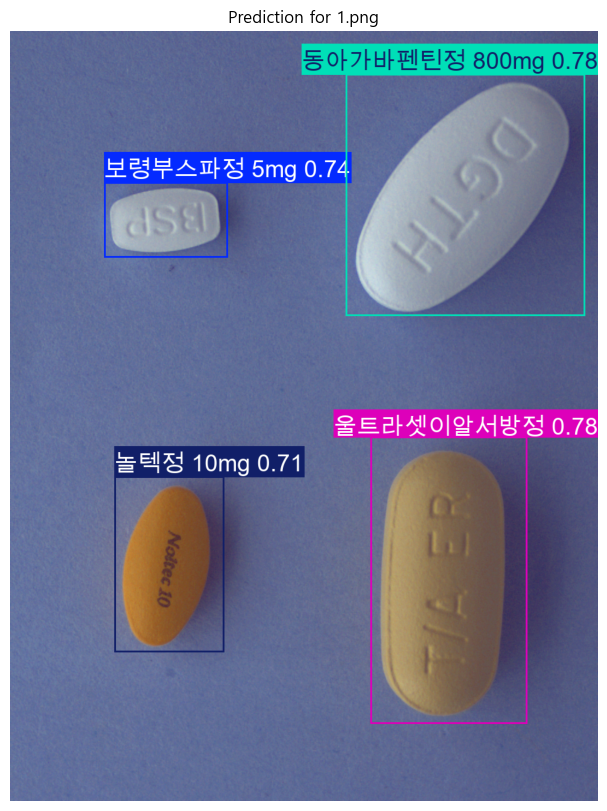

First image's detections:
  - Class: 울트라셋이알서방정 (YOLO ID: 51), Conf: 0.78, Bbox (norm xywh): [0.7465220093727112, 0.7130901217460632, 0.26633790135383606, 0.37296342849731445]
  - Class: 동아가바펜틴정 800mg (YOLO ID: 23), Conf: 0.78, Bbox (norm xywh): [0.7744122743606567, 0.21284492313861847, 0.4072182774543762, 0.3138113021850586]
  - Class: 보령부스파정 5mg (YOLO ID: 0), Conf: 0.74, Bbox (norm xywh): [0.26579466462135315, 0.2450096607208252, 0.2099650502204895, 0.09752360731363297]
  - Class: 놀텍정 10mg (YOLO ID: 44), Conf: 0.71, Bbox (norm xywh): [0.27055302262306213, 0.69260174036026, 0.1865272969007492, 0.2281760275363922]


In [21]:
# 추론 결과 시각화 예시 (옵션)
# inference_results는 Results 객체의 리스트입니다.
if inference_results:
    print("Displaying first inference result (if available)...")
    first_result = inference_results[0]
    im_bgr = first_result.plot() # BGR 이미지 (OpenCV 형식)
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB) # RGB로 변환 (matplotlib용)

    plt.figure(figsize=(10, 10))
    plt.imshow(im_rgb)
    plt.title(f"Prediction for {Path(first_result.path).name}")
    plt.axis('off')
    plt.show()

    # 바운딩 박스 정보 출력 예시
    print("First image's detections:")
    for box_data in first_result.boxes:
        cls = int(box_data.cls)
        conf = float(box_data.conf)
        xywh_norm = box_data.xywhn[0].tolist() # 정규화된 xywh

        # YOLO 클래스 ID를 실제 카테고리 이름으로 변환
        class_name = yolo_idx_to_name.get(cls, f"Unknown_{cls}")
        print(f"  - Class: {class_name} (YOLO ID: {cls}), Conf: {conf:.2f}, Bbox (norm xywh): {xywh_norm}")

In [22]:
# ====================================================================
# (Optional) 임시 파일 삭제
# ====================================================================
shutil.rmtree(YOLO_LABELS_TEMP)
print(f"Removed temporary YOLO label directory: {YOLO_LABELS_TEMP}")

Removed temporary YOLO label directory: \Users\user\myproject\AI03-Project-1\data\processed\yolo_labels_temp
